# Hands-on Exercise #5
## Predicting Song Popularity

In [1]:
# 1. Import libraries
import pandas as pd
import numpy as np
import re
import string
import spacy

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

print("--- Libraries Loaded Successfully ---")

--- Libraries Loaded Successfully ---


In [2]:
# 2. Load dataset
df = pd.read_csv('spotify_songs.csv')
print(f"Dataset loaded. Shape: {df.shape}")

Dataset loaded. Shape: (18454, 25)


Median popularity: 48.0
Target 'hit' variable created (1 = popular song, 0 = not popular)
Median popularity: 48.0
Target 'hit' variable created (1 = popular song, 0 = not popular)


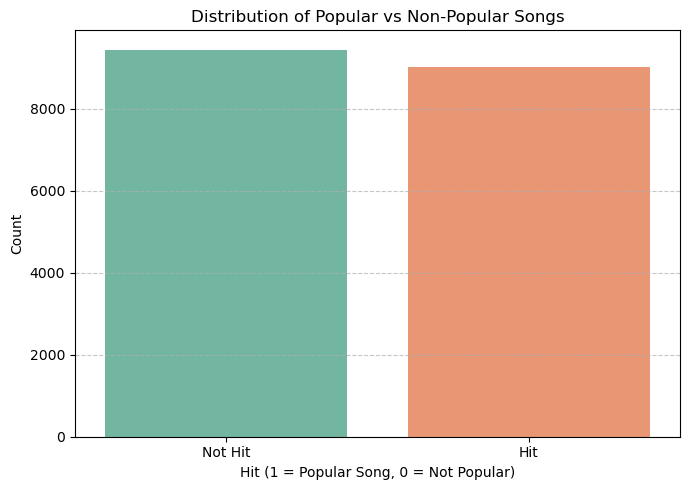

In [26]:
# 3. Define Target Variable
median_popularity = df['track_popularity'].median()
df['hit'] = np.where(df['track_popularity'] > median_popularity, 1, 0)
print(f"Median popularity: {median_popularity}")
print("Target 'hit' variable created (1 = popular song, 0 = not popular)")
# 3. Define Target Variable
median_popularity = df['track_popularity'].median()
df['hit'] = np.where(df['track_popularity'] > median_popularity, 1, 0)
print(f"Median popularity: {median_popularity}")
print("Target 'hit' variable created (1 = popular song, 0 = not popular)")

# --- Good Plot: Hit vs Non-hit Distribution ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,5))
sns.countplot(x='hit', data=df, palette='Set2')
plt.title('Distribution of Popular vs Non-Popular Songs')
plt.xlabel('Hit (1 = Popular Song, 0 = Not Popular)')
plt.ylabel('Count')
plt.xticks([0,1], ['Not Hit', 'Hit'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [4]:
# 4. Text Preprocessing (Lyrics)
# Handle missing lyrics
df['lyrics'] = df['lyrics'].fillna('')

# Load SpaCy model
nlp = spacy.load('en_core_web_sm')
print("SpaCy English model loaded for NER.")

# Function to clean lyrics
def clean_text(text):
    text = text.lower()
    text = re.sub(f'[{string.punctuation}]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning
df['clean_lyrics'] = df['lyrics'].apply(clean_text)
print("Lyrics cleaned (lowercase, remove punctuation, digits, extra spaces)")

SpaCy English model loaded for NER.
Lyrics cleaned (lowercase, remove punctuation, digits, extra spaces)


In [5]:
# Named Entity Recognition (NER) - extracting named entities count
def count_named_entities(text):
    doc = nlp(text)
    return len(doc.ents)

df['ner_count'] = df['clean_lyrics'].apply(count_named_entities)
print("NER feature (number of named entities per song) created.")

NER feature (number of named entities per song) created.


In [6]:
# N-gram modeling (Bigrams using CountVectorizer)
vectorizer = CountVectorizer(ngram_range=(2,2), max_features=500)  # Bigram features
X_ngrams = vectorizer.fit_transform(df['clean_lyrics'])
print("Bigram features created using CountVectorizer.")

# TF-IDF Features
tfidf = TfidfVectorizer(max_features=500)
X_tfidf = tfidf.fit_transform(df['clean_lyrics'])
print("TF-IDF features created.")

Bigram features created using CountVectorizer.
TF-IDF features created.


In [7]:
# 5. Feature Combination
X_features = hstack((X_tfidf, X_ngrams, np.array(df['ner_count']).reshape(-1,1)))

# Optionally add audio features too
audio_features = ['tempo', 'loudness', 'energy']
for feature in audio_features:
    if feature in df.columns:
        X_features = hstack((X_features, np.array(df[feature]).reshape(-1,1)))
print(f"Final feature set shape: {X_features.shape}")
y = df['hit']

Final feature set shape: (18454, 1004)


In [8]:
# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.3, random_state=42)
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (12917, 1004), Test size: (5537, 1004)


In [9]:
# 7. Build Models
print("Training Logistic Regression...")
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Training Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

Training Logistic Regression...
Training Random Forest...


In [10]:
# 8. Evaluation Function
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

In [11]:
# 9. Collect Results
results = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

for model_name, y_pred in [('Logistic Regression', y_pred_lr), ('Random Forest', y_pred_rf)]:
    accuracy, precision, recall, f1 = evaluate_model(y_test, y_pred)
    results['Model'].append(model_name)
    results['Accuracy'].append(round(accuracy, 4))
    results['Precision'].append(round(precision, 4))
    results['Recall'].append(round(recall, 4))
    results['F1 Score'].append(round(f1, 4))

results_df = pd.DataFrame(results)

# Comparison of Models

In [13]:
# 11. Optional: Print classification reports
print("\nLogistic Regression Report:\n", classification_report(y_test, y_pred_lr))
print("\nRandom Forest Report:\n", classification_report(y_test, y_pred_rf))


Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.59      0.65      0.62      2817
           1       0.60      0.53      0.56      2720

    accuracy                           0.59      5537
   macro avg       0.59      0.59      0.59      5537
weighted avg       0.59      0.59      0.59      5537


Random Forest Report:
               precision    recall  f1-score   support

           0       0.58      0.67      0.63      2817
           1       0.60      0.50      0.55      2720

    accuracy                           0.59      5537
   macro avg       0.59      0.59      0.59      5537
weighted avg       0.59      0.59      0.59      5537




📊 Confusion Matrix: Logistic Regression


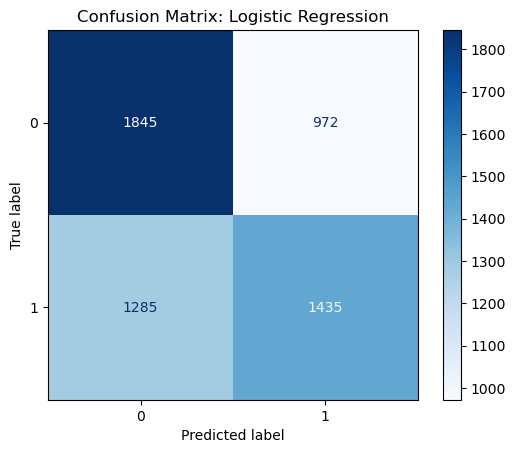


📊 Confusion Matrix: Random Forest


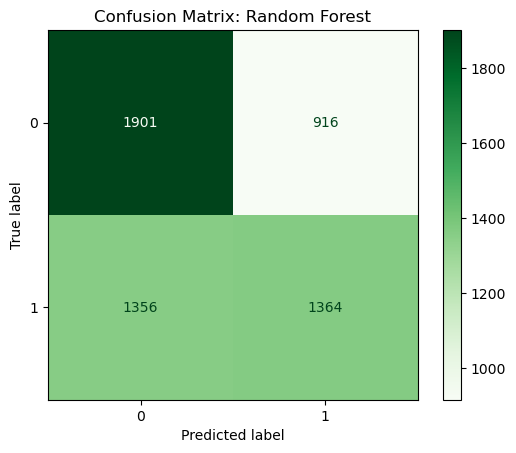

In [48]:
# --- Import Packages ---
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# --- Evaluate Models ---

# Define a function to evaluate and collect metrics
def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return {
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    }

# Evaluate Logistic Regression
logreg_results = evaluate_model('Logistic Regression', y_test, y_pred_lr)

# Evaluate Random Forest
rf_results = evaluate_model('Random Forest', y_test, y_pred_rf)

# --- Confusion Matrices ---
print("\n📊 Confusion Matrix: Logistic Regression")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, cmap='Blues')
plt.title('Confusion Matrix: Logistic Regression')
plt.show()

print("\n📊 Confusion Matrix: Random Forest")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap='Greens')
plt.title('Confusion Matrix: Random Forest')
plt.show()

In [46]:
# --- Model Performance Summary---

print("\n" + "="*60)
print("🎯 FINAL MODEL PERFORMANCE SUMMARY 🎯".center(60))
print("="*60)

summary_df = pd.DataFrame([logreg_results, rf_results])
summary_df = summary_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']]

print(summary_df.to_string(index=False))

print("="*60)


            🎯 FINAL MODEL PERFORMANCE SUMMARY 🎯             
              Model  Accuracy  Precision   Recall  F1 Score
Logistic Regression  0.592379   0.596178 0.527574  0.559782
      Random Forest  0.589669   0.598246 0.501471  0.545600


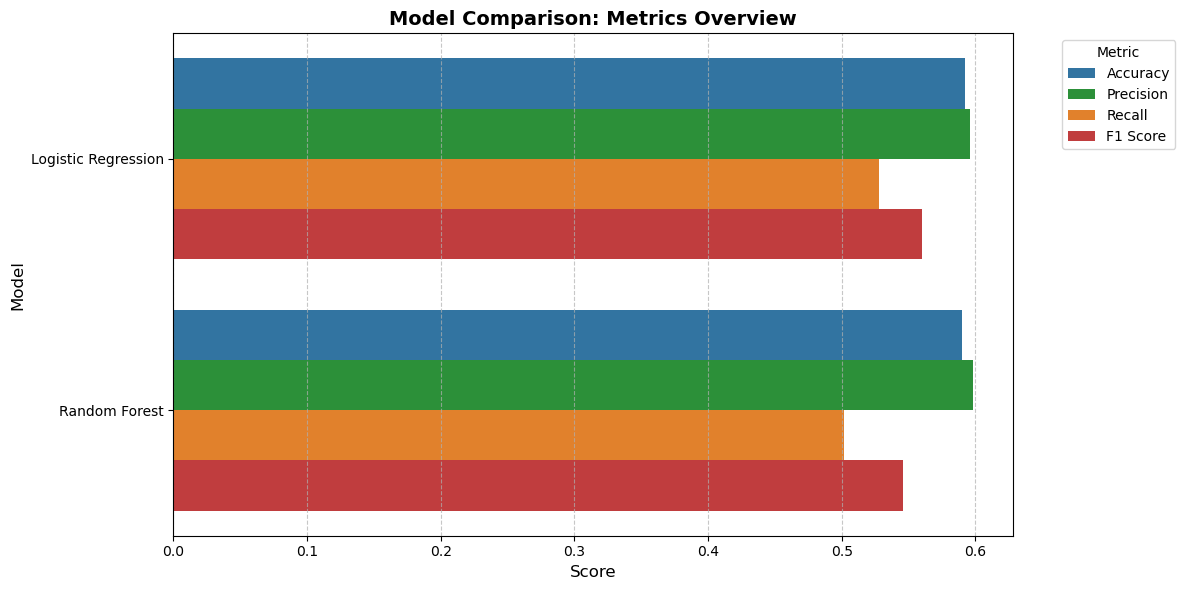

In [58]:
# Visualization with custom colors
plt.figure(figsize=(12, 6))

# Define a custom color palette
custom_palette = {
    'Accuracy': '#1f77b4',  # Blue
    'Precision': '#1ca02c', # Green
    'Recall': '#ff7f0e',    # Orange
    'F1 Score': '#d62728'   # Red
}

sns.barplot(
    data=results_df.melt(id_vars='Model', value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score']),
    x='value', y='Model', hue='variable', orient='h',
    palette=custom_palette
)

plt.title("Model Comparison: Metrics Overview", fontsize=14, fontweight='bold')
plt.xlabel("Score", fontsize=12)
plt.ylabel("Model", fontsize=12)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend out if crowded
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Key Insights

## 1. Logistic Regression performs slightly better overall
- **Accuracy** and **Precision** are marginally higher for Logistic Regression compared to Random Forest.
- **Recall** is also better for Logistic Regression, meaning it is slightly more effective at correctly identifying "hit" songs.

## 2. F1 Scores are close, but Logistic Regression still leads
- The **F1 Score**, which balances Precision and Recall, is slightly higher for Logistic Regression.
- This indicates that Logistic Regression maintains a better balance between catching true hits and avoiding false positives.

## 3. Recall is relatively lower compared to Precision for both models
- Both models show a drop in **Recall** compared to **Precision**, suggesting they are somewhat conservative.
- In practice, this means they tend to predict a song as a "hit" only when they are very confident.